In [20]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping
from pathlib import Path

In [21]:
'''d0默认值为10：
这是一个参数，用于定义高通滤波器的截止频率。d0 控制了滤波器对低频成分的衰减程度，即距离原点（0频率）多远的频率成分开始被衰减。

rl默认值为0.5：
这是滤波器在低频区域的增益。rl 控制了滤波器对低频成分的保留程度。

rh默认值为2.0：
这是滤波器在高频区域的增益。rh 控制了滤波器对高频成分的增强程度。

c默认值为4：
这是一个参数，用于控制滤波器的陡峭程度。c 的值越大，滤波器的过渡带就越窄，即从低频到高频的过渡就越快。

h默认值为2.0：
这是输出图像的最大值。在同态滤波过程中，可能会产生超出常规图像值范围（0-255）的结果，h 用于将结果缩放到这个最大值。

l默认值为0.5：
这是输出图像的最小值。与 h 类似，l 用于确保输出图像的值不会低于这个最小值。'''
def homomorphic_filter(src, d0=10, rl=1, rh=2, c=4, h=2.0, l=0.5):
    gray = src.copy()
    gray = np.log(1e-5 + gray)  # 取对数
    rows, cols = gray.shape
    gray_fft = np.fft.fft2(gray)  # FFT傅里叶变换
    gray_fftshift = np.fft.fftshift(gray_fft)  # FFT中心化
    M, N = np.meshgrid(np.arange(-cols // 2, cols // 2), np.arange(-rows // 2, rows // 2))
    D = np.sqrt(M ** 2 + N ** 2)  # 计算距离
    Z = (rh - rl) * (1 - np.exp(-c * (D ** 2 / d0 ** 2))) + rl  # H(u,v)传输函数
    dst_fftshift = Z * gray_fftshift
    dst_fftshift = (h - l) * dst_fftshift + l
    dst_ifftshift = np.fft.ifftshift(dst_fftshift)
    dst_ifft = np.fft.ifft2(dst_ifftshift)  # IFFT逆傅里叶变换
    dst = np.real(dst_ifft)  # IFFT取实部
    dst = np.exp(dst) - 1  # 还原
    dst = np.uint8(np.clip(dst, 0, 255))
    return dst

In [22]:
def calgraylevel(image_gray,imgname):
    # 计算直方图
    histogram = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
    histogram = histogram.ravel()  # 将直方图展平为一维数组,频率
    # 找到峰值对应的灰度级
    imax = np.argmax(histogram)  # imax是直方图最大值的索引，即峰值灰度级
    imin = np.argmin(histogram)
    f_max = histogram[imax]  # f_max是imax对应的频率值，即峰值频率

    xdata = np.arange(imax)#灰度
    ydata = histogram[:imax]#频率
    #ydata = ydata.ravel() / image_gray.size
    plt.plot(ydata)
    plt.savefig(f'saveimg/{imgname}_gray.png')
    plt.close()
    # 定义分段函数
    def piecewise(x,x0,x1,y0,y1,k0,k1):
        return np.piecewise(x , [x <= x0, np.logical_and(x0<x, x<x1),x>x1] ,
                            [lambda x:k0*(x-x0) + y0,#根据点斜式构建函数
                            lambda x:(x-x0)*(y1-y0)/(x1-x0)+y0,#根据两点式构建函数
                            lambda x:k1*(x-x1) + y1])

    #根据分段函数进行拟合，通过迭代寻找最优的p，即为p_best
    #注：p（p_best）中包含的是拟合之后求得的所有未知参数
    perr_min = np.inf
    for n in range(100):
        k = np.random.rand(6)*20
        #k=np.array([10,20,10,10,10,0])
        p , e = curve_fit(piecewise, xdata, ydata,p0=k)
        perr = np.sum(np.abs(ydata-piecewise(xdata, *p)))
        if(perr < perr_min):
            perr_min = perr
            p_best = p

    #print(f"p_best{p_best}")
    #根据p_best调用curve_fit函数绘制拟合图像
    xd = np.linspace(0, imax, 100)
    if_=p_best[0]
    it_=p_best[1]
    #print(if_,it_)
    plt.figure()

    plt.plot(xd, piecewise(xd, *p_best))
    xx=(p_best[0],p_best[1])
    yy=(p_best[2],p_best[3])

    plt.scatter(xx,yy,s=30,c='black')
    plt.savefig(f'saveimg/{imgname}_gray2.png')
    plt.close()
    

    # 广义伽马校正公式拟合
    def gamma_func(x, alpha, delta, gamma):
        return 255 * (x / 255) ** (alpha / (x + delta) + gamma)

    # 使用已知点拟合参数
    #popt, _ = curve_fit(gamma_func, np.array([0, imin, if_, it_, 255]), np.array([0, 0, if_, imax, 255]))
    #alpha, delta, gamma = popt

    # 初始参数猜测
    initial_guess = [120.0, 1.0, 1.0]

    # 迭代拟合
    def iterative_fit(xdata, ydata, initial_guess, max_iter=10, tol=1e-6):
        popt, pcov = curve_fit(gamma_func, xdata, ydata, p0=initial_guess)
        for _ in range(max_iter - 1):
            new_popt, new_pcov = curve_fit(gamma_func, xdata, ydata, p0=popt,method='dogbox')
            if np.allclose(new_popt, popt, atol=tol):
                break
            popt = new_popt
        return popt, pcov

    # 执行迭代拟合
    popt, pcov = iterative_fit(np.array([0, imin, if_, it_, 255]), np.array([0, 0, if_, imax, 255]), initial_guess)
    alpha, delta, gamma = popt

    #print("Optimized parameters:", popt)

    # 应用广义伽马校正
    corrected_image = np.clip(gamma_func(image_gray, alpha, delta, gamma), 0, 255).astype(np.uint8)


    # 假设你已经有了以下变量
    # image_gray: 灰度图像
    # imin, if_, it_, imax: 已知的灰度级点
    # alpha, delta, gamma: 拟合得到的参数

    # 广义伽马校正公式
    #if if_==0:
    #    if_=5
    # 已知点
    x_data = np.array([0, imin, if_, it_, 255])
    y_data = np.array([0, 0, if_, imax, 255])

    # 绘制原始数据点
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='red', label='Original Data Points')

    # 绘制拟合曲线
    x_fit = np.linspace(0, 255, 256)
    y_fit = gamma_func(x_fit, alpha, delta, gamma)
    plt.plot(x_fit, y_fit, label='Fitted Gamma Curve')

    x1, y1 = 0, 0
    x2, y2 = 255, 255

    # 使用plot函数绘制两点之间的连线
    plt.plot([x1, x2], [y1, y2],color='black')  # marker='o'表示在每个点上放置一个圆圈标记

    # 设置图表标题和标签
    plt.title('Gamma Correction Fitting')
    plt.xlabel('Input Intensity Values')
    plt.ylabel('Output Intensity Values')
    plt.savefig(f'saveimg/{imgname}_gammacorrection.png')
    plt.close()

    return corrected_image

In [23]:
from scipy import ndimage
import SimpleITK as sitk 

class vesselness2d:
    def __init__(self, image, sigma, spacing, tau):
        super(vesselness2d, self).__init__()
        # image 为numpy类型，表示n * m 的二维矩阵。
        self.image = image
        # sigma 为list 类型，表示高斯核的尺度。
        self.sigma = sigma
        # spacing 为list类型，表示.nii文件下某一切面下的体素的二维尺寸。如果输入图像本身为二维图像，则为[1,1],如果为三维图像，则为对应的space。
        self.spacing = spacing
        # tau 为float类型，表示比例系数。
        self.tau = tau
        # 图像尺寸
        self.size = image.shape
	
	# 使用特定的特定sigma尺寸下的高斯核对图像滤波
	# 这里作者并没有使用n*n的卷积核，而是分别使用n*1，1*n的卷积对图像进行x和y方向上的卷积，
	# 并且使用的是最原始的计算高斯函数得到卷积核，而不是直接用现成的高斯卷积核，
	# 通过证明可以发现在两方面的结果是等价的。
    def gaussian1(self, image, sigma):
        
        return cv2.GaussianBlur(image,(0,0),sigma)

    def gaussian(self, image, sigma):
        siz = sigma * 6 # 核的尺寸
        
        # x轴方向上的滤波
        temp = round(siz / self.spacing[0] / 2)
        x = [i for i in range(-temp, temp + 1)]
        x = np.array(x)
        H = np.exp(-(x ** 2 / (2 * ((sigma / self.spacing[0]) ** 2))))
        H = H / np.sum(H)
        Hx = H.reshape(len(H), 1)
        I = ndimage.convolve(image, Hx, mode='nearest')
        
        # y轴方向上的滤波
        temp = round(siz / self.spacing[1] / 2)
        x = [i for i in range(-temp, temp + 1)]
        x = np.array(x)
        H = np.exp(-(x ** 2 / (2 * ((sigma / self.spacing[1]) ** 2))))
        H = H / np.sum(H[:])
        Hy = H.reshape(1, len(H))
        I = ndimage.convolve(I, Hy, mode='nearest')
        return I

	# 求图像的梯度
    def gradient2(self, F, option):
        k = self.size[0]
        l = self.size[1]
        D = np.zeros(F.shape)
        if option == "x":
            D[0, :] = F[1, :] - F[0, :]
            D[k - 1, :] = F[k - 1, :] - F[k - 2, :]
            # take center differences on interior points
            D[1:k - 2, :] = (F[2:k - 1, :] - F[0:k - 3, :]) / 2
        else:
            D[:, 0] = F[:, 1] - F[:, 0]
            D[:, l - 1] = F[:, l - 1] - F[:, l - 2]
            D[:, 1:l - 2] = (F[:, 2:l - 1] - F[:, 0:l - 3]) / 2
        return D
        
	# 求海森矩阵中所需要的二阶偏导数
    def Hessian2d(self, image, sigma):
        image = self.gaussian(image, sigma)
        # image = ndimage.gaussian_filter(image, sigma, mode = 'nearest')
        Dy = self.gradient2(image, "y")
        Dyy = self.gradient2(Dy, "y")

        Dx = self.gradient2(image, "x")
        Dxx = self.gradient2(Dx, "x")
        Dxy = self.gradient2(Dx, 'y')
        return Dxx, Dyy, Dxy
	
	# 求解海森矩阵的两个特征值
	# 这里作者使用求根公式，将二阶海森矩阵展开，a=1,b=-(Ixx+Iyy),c=(Ixx*Iyy-Ixy*Ixy) 
	# 首先计算 sqrt(b^2 - 4ac),通过化简得到tmp
	# 最后得到两个特征值mu1，mu2，根据大小关系，大的为mu2，小的为mu1
    def eigvalOfhessian2d(self, Dxx, Dyy, Dxy):
        tmp = np.sqrt((Dxx - Dyy) ** 2 + 4 * (Dxy ** 2))
        # compute eigenvectors of J, v1 and v2
        mu1 = 0.5 * (Dxx + Dyy + tmp)
        mu2 = 0.5 * (Dxx + Dyy - tmp)
        # Sort eigen values by absolute value abs(Lambda1) < abs(Lambda2)
        indices = (np.absolute(mu1) > np.absolute(mu2))
        Lambda1 = mu1
        Lambda1[indices] = mu2[indices]

        Lambda2 = mu2
        Lambda2[indices] = mu1[indices]
        return Lambda1, Lambda2

    def imageEigenvalues(self, I, sigma):
        hxx, hyy, hxy = self.Hessian2d(I, sigma)
        c = sigma ** 2
        hxx = -c * hxx
        hyy = -c * hyy
        hxy = -c * hxy

        # 为了降低运算量，去掉噪声项的计算
        B1 = -(hxx + hyy)
        B2 = hxx * hyy - hxy ** 2
        T = np.ones(B1.shape)
        T[(B1 < 0)] = 0
        T[(B1 == 0) & (B2 == 0)] = 0
        T = T.flatten()
        indeces = np.where(T == 1)[0]

        hxx = hxx.flatten()
        hyy = hyy.flatten()
        hxy = hxy.flatten()

        hxx = hxx[indeces]
        hyy = hyy[indeces]
        hxy = hxy[indeces]


        lambda1i, lambda2i = self.eigvalOfhessian2d(hxx, hyy, hxy)
        lambda1 = np.zeros(self.size[0] * self.size[1], )
        lambda2 = np.zeros(self.size[0] * self.size[1], )

        lambda1[indeces] = lambda1i
        lambda2[indeces] = lambda2i

        # 去掉噪声
        lambda1[(np.isinf(lambda1))] = 0
        lambda2[(np.isinf(lambda2))] = 0

        lambda1[(np.absolute(lambda1) < 1e-4)] = 0
        lambda1 = lambda1.reshape(self.size)

        lambda2[(np.absolute(lambda2) < 1e-4)] = 0
        lambda2 = lambda2.reshape(self.size)
        return lambda1, lambda2
	
	# 血管强化
    def vesselness2d(self):
        for j in range(len(self.sigma)):
            lambda1, lambda2 = self.imageEigenvalues(self.image, self.sigma[j])
            lambda3 = lambda2.copy()
            new_tau = self.tau * np.min(lambda3)
            lambda3[(lambda3 < 0) & (lambda3 >= new_tau)] = new_tau
            different = lambda3 - lambda2
            response = ((np.absolute(lambda2) ** 2) * np.absolute(different)) * 27 / (
                        (2 * np.absolute(lambda2) + np.absolute(different)) ** 3)
            response[(lambda2 < lambda3 / 2)] = 1
            response[(lambda2 >= 0)] = 0

            response[np.where(np.isinf(response))[0]] = 0
            if j == 0:
                vesselness = response
            else:
                vesselness = np.maximum(vesselness, response)
        vesselness[(vesselness < 1e-2)] = 0
        return vesselness



In [24]:
def areathreshold_denoising(image):
    # 应用二值化处理
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    # 检测轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 计算自适应面积阈值（例如取轮廓面积的平均值）
    areas = [cv2.contourArea(cnt) for cnt in contours]
    mean_area = np.mean(areas)

    # 设定阈值比例（可以根据需求调整）
    area_threshold = 0.5 * mean_area

    # 创建一个空白图像用于绘制符合面积阈值的轮廓

    output = np.zeros(image.shape[:2], dtype='uint8')  # 仅取宽高两维

    # 筛选并绘制符合条件的轮廓
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= area_threshold:  # 保留面积大于阈值的轮廓
            cv2.drawContours(output, [cnt], -1, (255), thickness=cv2.FILLED)

    areathreshold_img = output
    
    return areathreshold_img


In [25]:
def closing(image):
    # 创建一个5x5的矩形结构元素
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # 创建一个5x5的椭圆形结构元素
    ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))

    # 创建一个5x5的十字形结构元素
    cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))


    kernel = np.ones((5, 5), np.uint8)

    # 进行闭运算
    closing_img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, ellipse_kernel)

    return closing_img

def dilated(image):
    # 二值化处理，根据需要调整阈值
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # 定义结构元素，这里使用一个3x3的矩形结构元素
    # 创建一个5x5的矩形结构元素
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # 创建一个5x5的椭圆形结构元素
    ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    # 创建一个5x5的十字形结构元素
    cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7))


    # 执行膨胀操作
    dilated_image = cv2.dilate(binary_image, ellipse_kernel, iterations=5)

    return dilated_image

In [26]:
def zhang_suen_thinning1(image):
    # 确保图像为二值化图像
    binary_image = (image > 0).astype(np.uint8)

    def neighbours(x, y):
        """返回给定像素的 8 个邻居像素的值"""
        return [binary_image[x-1, y], binary_image[x-1, y+1], binary_image[x, y+1], binary_image[x+1, y+1],
                binary_image[x+1, y], binary_image[x+1, y-1], binary_image[x, y-1], binary_image[x-1, y-1]]

    def transitions(neighbours):
        """计算从 0 到 1 的转换次数"""
        n = neighbours + neighbours[0:1]  # 环绕一下
        return sum((n1 == 0 and n2 == 1) for n1, n2 in zip(n[:-1], n[1:]))

    def step1():
        """第一步移除点集"""
        to_remove = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                P = neighbours(i, j)
                if (binary_image[i, j] == 1 and
                    2 <= sum(P) <= 6 and
                    transitions(P) == 1 and
                    P[0] * P[2] * P[4] == 0 and
                    P[2] * P[4] * P[6] == 0):
                    to_remove.append((i, j))
        for i, j in to_remove:
            binary_image[i, j] = 0

    def step2():
        """第二步移除点集"""
        to_remove = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                P = neighbours(i, j)
                if (binary_image[i, j] == 1 and
                    2 <= sum(P) <= 6 and
                    transitions(P) == 1 and
                    P[0] * P[2] * P[6] == 0 and
                    P[0] * P[4] * P[6] == 0):
                    to_remove.append((i, j))
        for i, j in to_remove:
            binary_image[i, j] = 0

    # 执行迭代细化步骤，直到没有像素再被移除
    prev_image = np.zeros(binary_image.shape, np.uint8)
    while True:
        step1()
        step2()
        if np.array_equal(prev_image, binary_image):
            break
        prev_image = binary_image.copy()

    return binary_image


In [27]:
def check_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"文件夹 '{directory}' 不存在，已成功创建。")
    else:
        print(f"文件夹 '{directory}' 已存在。")


# 指定要检查的目录路径
directory_paths = ['saveimg']
for path in directory_paths:
    # 调用函数检查并创建目录
    check_directory(path)

文件夹 'saveimg' 已存在。


In [28]:
# 指定文件夹路径
folder_path = 'testphotos'
# 获取文件夹下的所有文件和子文件夹
files_and_folders = os.listdir(folder_path)
# 过滤出文件
photoname = [file for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
photopath = [os.path.join(folder_path, file) for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
print(photopath)
print(photoname)

['testphotos\\1.png', 'testphotos\\11.jpg', 'testphotos\\2.png', 'testphotos\\img copy 2.png', 'testphotos\\img copy.png', 'testphotos\\img.png']
['1.png', '11.jpg', '2.png', 'img copy 2.png', 'img copy.png', 'img.png']


C:\Users\64473\AppData\Local\Temp\ipykernel_6944\3395324476.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  p , e = curve_fit(piecewise, xdata, ydata,p0=k)
C:\Users\64473\AppData\Local\Temp\ipykernel_6944\2330330821.py:145: RuntimeWarning: invalid value encountered in divide
  response = ((np.absolute(lambda2) ** 2) * np.absolute(different)) * 27 / (
C:\Users\64473\AppData\Local\Temp\ipykernel_6944\3395324476.py:54: RuntimeWarning: divide by zero encountered in power
  return 255 * (x / 255) ** (alpha / (x + delta) + gamma)


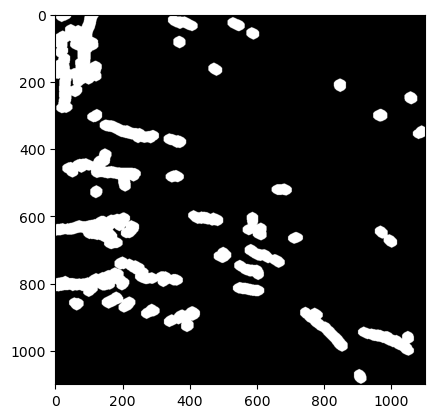

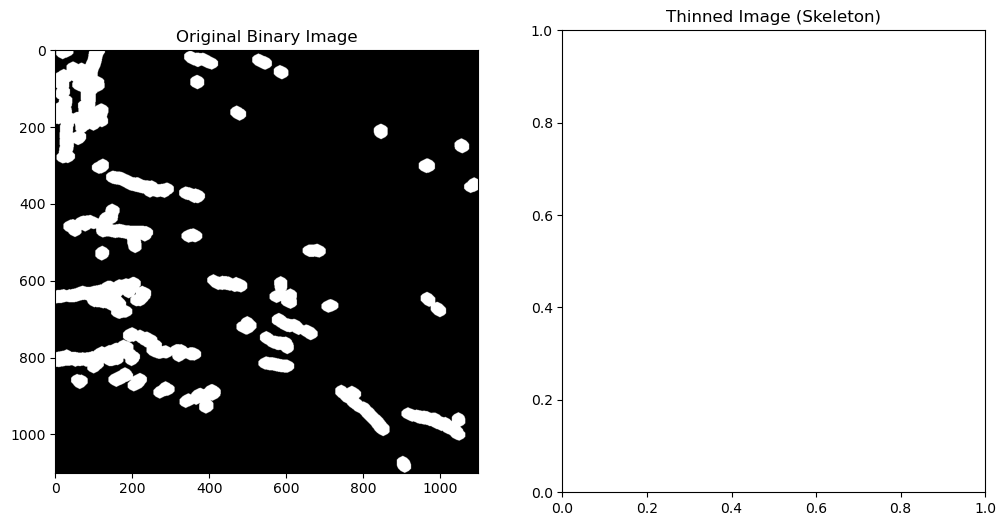

In [29]:
for imgpath in photopath:
    imgname = os.path.basename(imgpath)
    # read image files
    image_color = cv2.imread(imgpath)
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

    graylevelimg = calgraylevel(image_gray,imgname)
    
    image_homomorphic_filter = homomorphic_filter(graylevelimg)
    plt.imshow(image_homomorphic_filter, cmap='gray')
    plt.title('homomorphic_filter')
    plt.savefig(f'saveimg/{imgname}_homomorphic_filter.png', bbox_inches='tight')
    plt.close()


    #convert forgeground to background and vice-versa
    image = np.array(image_homomorphic_filter)

    thr = np.percentile(image[(image > 0)], 1)*0.9
    image[(image <= thr)] = thr
    image = image - np.min(image)
    image = image / np.max(image)
    #sigma=[0.5,1, 1.5, 2, 2.5]
    sigma=[3]
    spacing = [1, 1]
    tau = 3

    output = vesselness2d(image, sigma, spacing, tau)
    vessleness_img = output.vesselness2d()

    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.title("Original Binary Image")
    plt.imshow(image_homomorphic_filter, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Thinned Image (Skeleton)")
    plt.imshow(vessleness_img, cmap='gray')
    plt.savefig(f'saveimg/{imgname}_vesselness2d.png', bbox_inches='tight')
    plt.close()


    vesselness_img_scaled = (vessleness_img * 255).astype(np.uint8)
    # threshold
    ret, thresh = cv2.threshold(vesselness_img_scaled, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #print(ret)  # 124
    # adaptive threshold
    thresh1 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
    thresh2 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh3 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    thresh4 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # show image
    plt.figure('adaptive threshold', figsize=(12, 8))
    plt.subplot(231), plt.imshow(vesselness_img_scaled, cmap='gray'), plt.title('original')
    plt.subplot(234), plt.imshow(thresh, cmap='gray'), plt.title('otsu')
    plt.subplot(232), plt.imshow(thresh1, cmap='gray'), plt.title('adaptive_mean_0')
    plt.subplot(235), plt.imshow(thresh2, cmap='gray'), plt.title('adaptive_mean_2')
    plt.subplot(233), plt.imshow(thresh3, cmap='gray'), plt.title('adaptive_gaussian_0')
    plt.subplot(236), plt.imshow(thresh4, cmap='gray'), plt.title('adaptive_gaussian_2')
    plt.savefig(f'saveimg/{imgname}_adaptive threshold.png', bbox_inches='tight')
    plt.close()

    areathreshold_img = areathreshold_denoising(thresh)
    plt.imshow(areathreshold_img, cmap='gray')
    plt.savefig(f'saveimg/{imgname}_areathreshold_img.png', bbox_inches='tight')
    closing_img = closing(areathreshold_img)
    plt.imshow(closing_img, cmap='gray')
    plt.savefig(f'saveimg/{imgname}_closing_img.png', bbox_inches='tight')
    dilated_img = dilated(closing_img)
    plt.imshow(dilated_img, cmap='gray')
    plt.savefig(f'saveimg/{imgname}_dilated_img.png', bbox_inches='tight')


    #thinning_img1 = zhang_suen_thinning1(dilated_img)


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Binary Image")
    plt.imshow(dilated_img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Thinned Image (Skeleton)")
    #plt.imshow(thinning_img1, cmap='gray')
    plt.savefig(f'saveimg/{imgname}_thinning_img.png', bbox_inches='tight')
